# Importing the required modules

In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules for lstm
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping

# Module for facebook prophet
import prophet

# Modules used for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import model

# Modules used for preprocessing
from datetime import datetime, timedelta
import preprocess
from model import Model

# Modules used for object oriented programming
from abc import ABC, abstractmethod

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=False)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [4]:
electricity0 = electricity[["cluster_0"]]
electricity23 = electricity[["cluster_2", "cluster_3", "cluster_1", "cluster_4"]]

In [5]:
electricity23 = electricity23[366:]

In [6]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

# SARIMAX

In [15]:
# class for SARIMAX model
class SARIMAX_model(Model):
    
    def __init__(self, data, exogs, cluster: str, start_index = 0, window_stride = 28):
        """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            exogs: the exogeneous variables particularly for SARIMAX.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class SARIMA.
        """
        super().__init__(data, cluster, start_index, window_stride)
        self.exogs = exogs
    
    # trains the model
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 0), 
                        seasonal_order = (1, 1, 0, 12))
        return model.fit()
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])

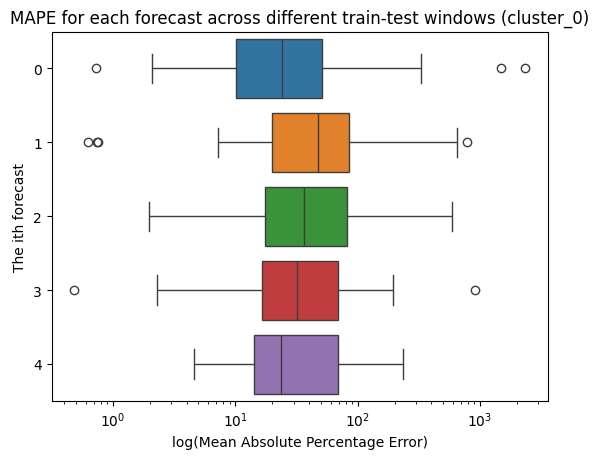

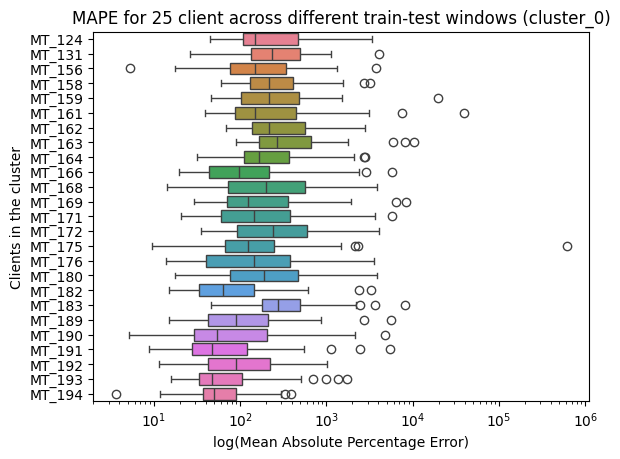

In [16]:
m = SARIMAX_model(electricity0, weather, "cluster_0")
m.cross_validate()
m.mape_boxplot_by_step()
m.mape_boxplot_by_client(25)

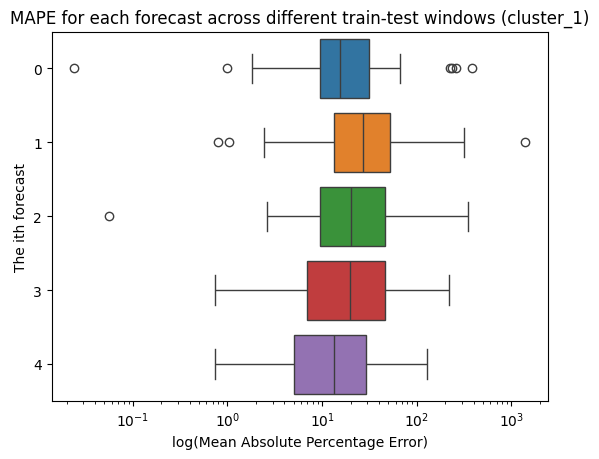

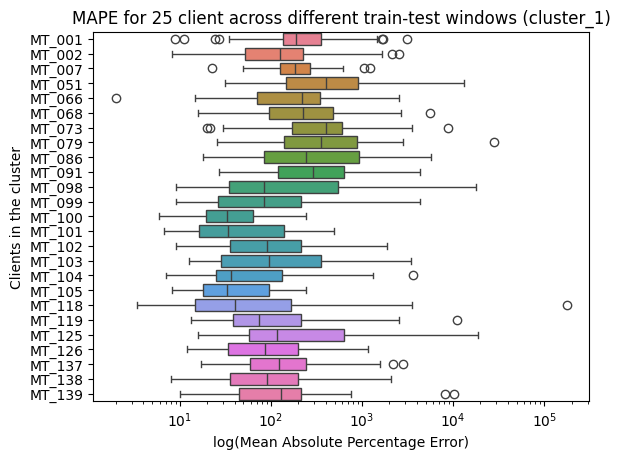

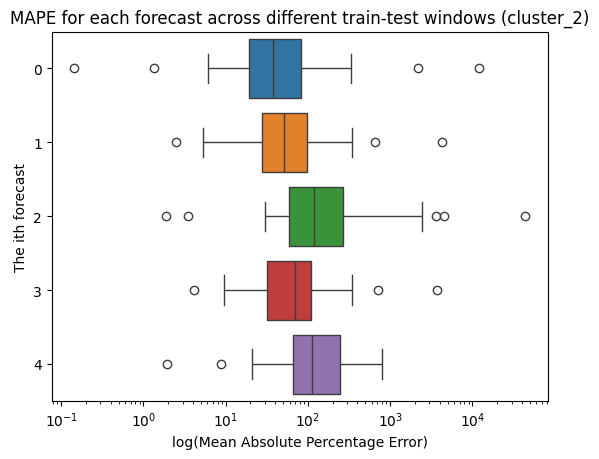

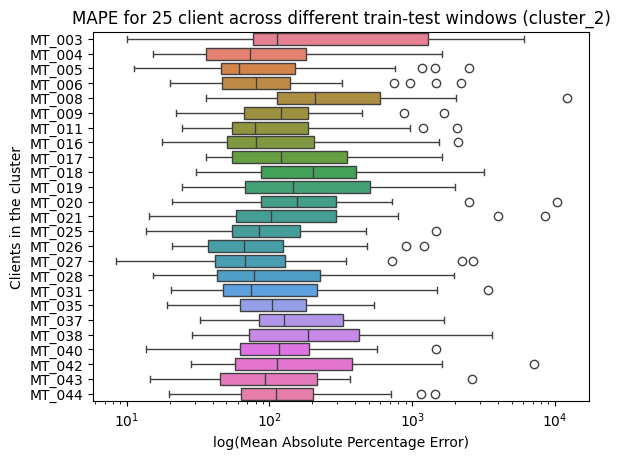

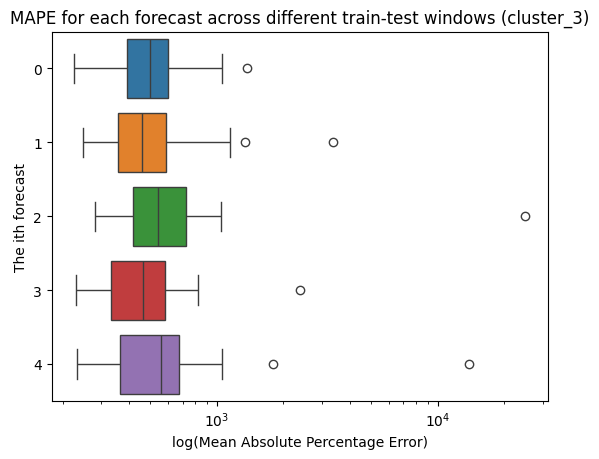

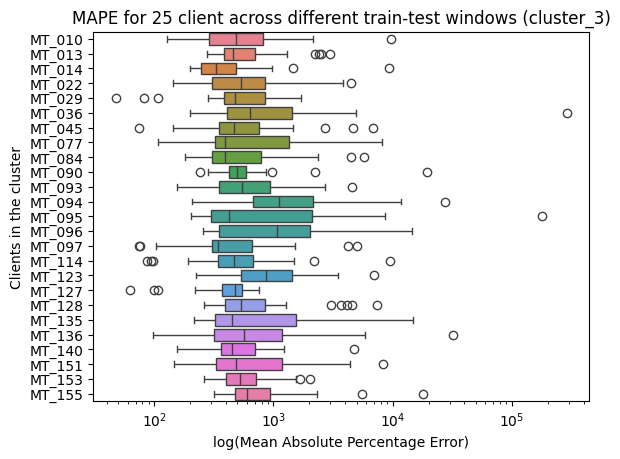

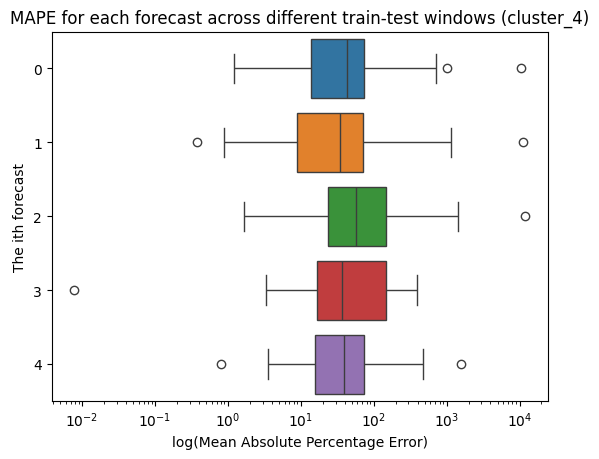

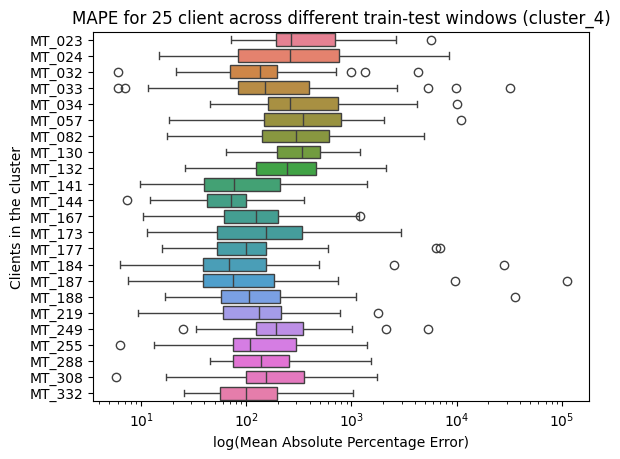

In [17]:
c = ["cluster_1", "cluster_2", "cluster_3", "cluster_4"]
for i in c:
    m = SARIMAX_model(electricity23, weather[366:], i, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_step()
    m.mape_boxplot_by_client(25)

# Facebook Prophet

In [25]:
class FacebookProphet_model(Model):
    
    def __init__(self, exogs, data, cluster, start_index = 0, window_stride = 28):
        super().__init__(data, cluster, start_index, window_stride)
        self.exogs = exogs

    def restructure(self, df):
        df = df.reset_index()
        df["date"] = pd.to_datetime(df["date"])
        df = df.merge(self.exogs.reset_index())
        df = df.rename({"date": "ds", self.cluster:"y"}, axis=1)
        return df

    def train_model(self, train, train_idx):
        model = prophet.Prophet()
        for col in self.exogs.columns:
                model.add_regressor(col)

        #print(train.columns, self.exogs.columns)
        train = self.restructure(train)
        return model.fit(train.reset_index())
    
    def get_forecasts(self, test, test_idx):

        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        df = self.restructure(df.rename({"ds": "date"}, axis = 1)).drop(["index"], axis = 1)

        return self.trained_model.predict(df)["yhat"][self.ts_train:self.ts_train + self.ts_test]

18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1]

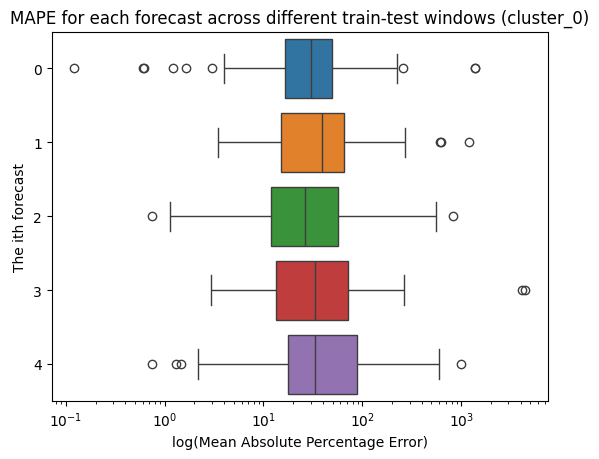

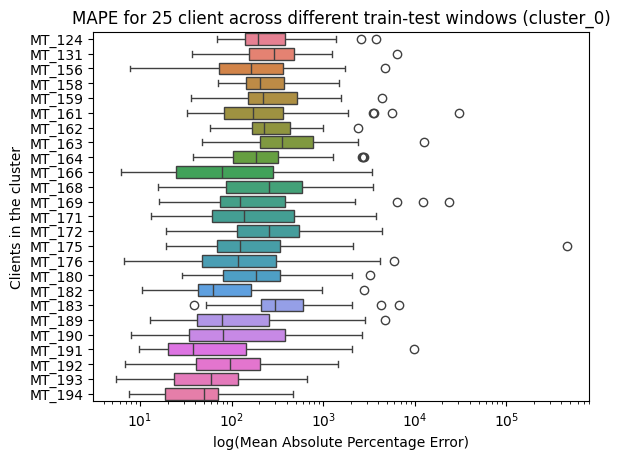

In [32]:
m = FacebookProphet_model(weather, electricity0, "cluster_0")
m.cross_validate()
m.mape_boxplot_by_step()
m.mape_boxplot_by_client(25)

18:13:23 - cmdstanpy - INFO - Chain [1] start processing
18:13:23 - cmdstanpy - INFO - Chain [1] done processing
18:13:23 - cmdstanpy - INFO - Chain [1] start processing
18:13:23 - cmdstanpy - INFO - Chain [1] done processing
18:13:23 - cmdstanpy - INFO - Chain [1] start processing
18:13:23 - cmdstanpy - INFO - Chain [1] done processing
18:13:23 - cmdstanpy - INFO - Chain [1] start processing
18:13:23 - cmdstanpy - INFO - Chain [1] done processing
18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing
18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing
18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing
18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing
18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1]

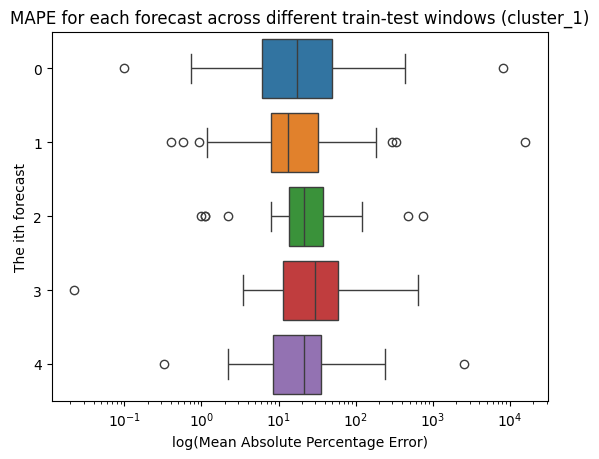

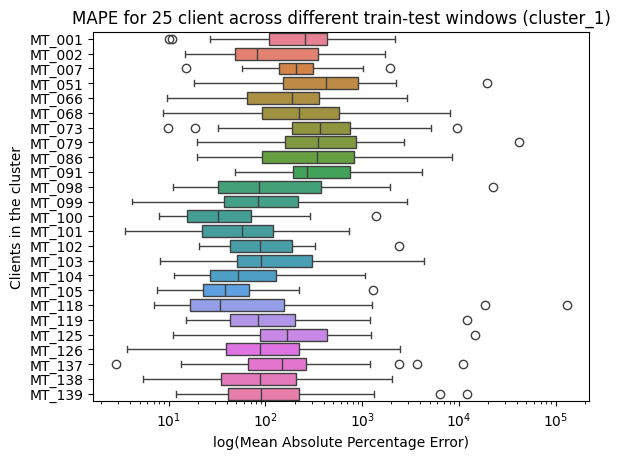

18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1]

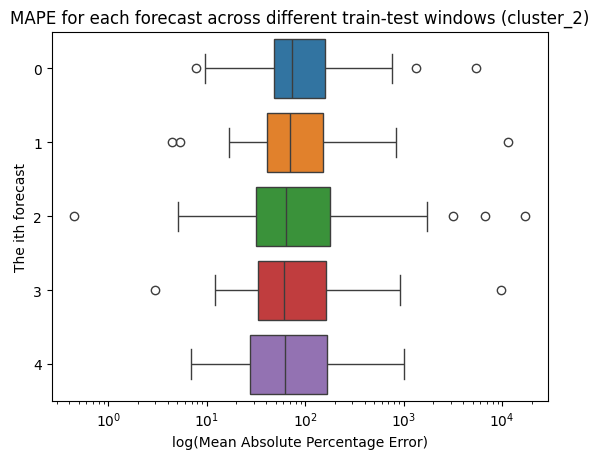

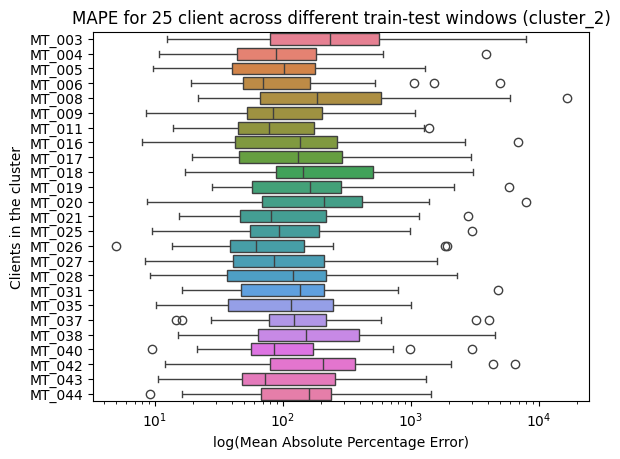

18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1]

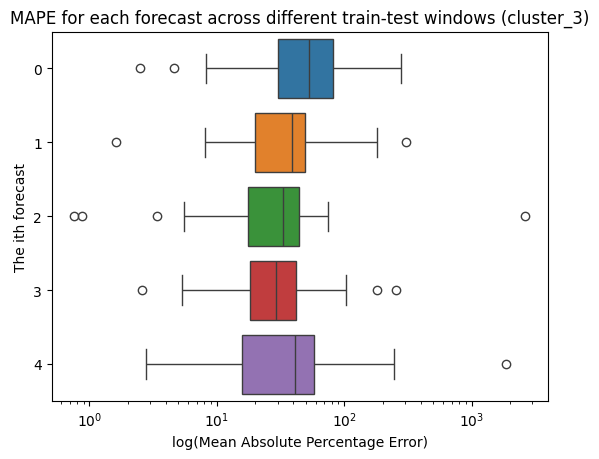

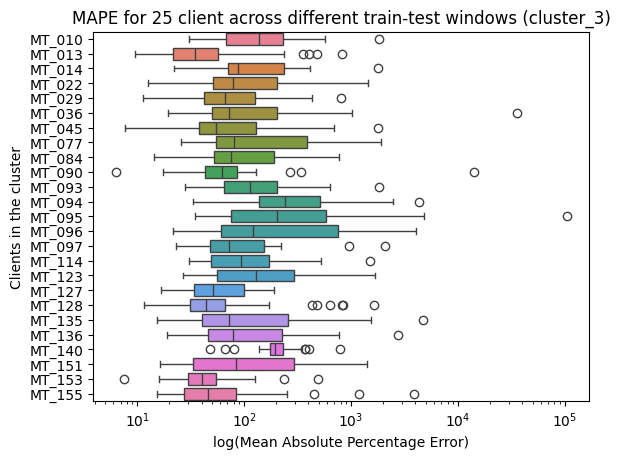

18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1]

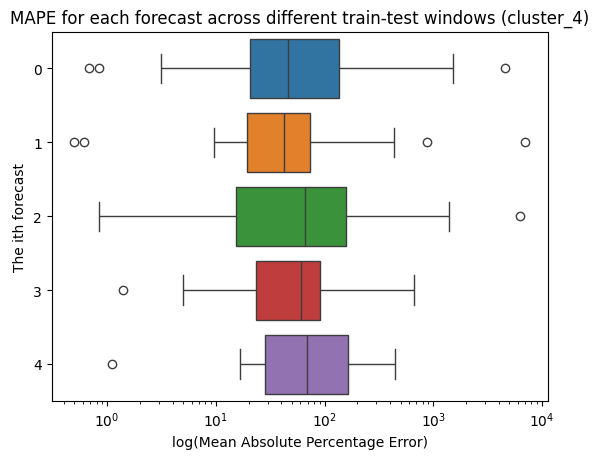

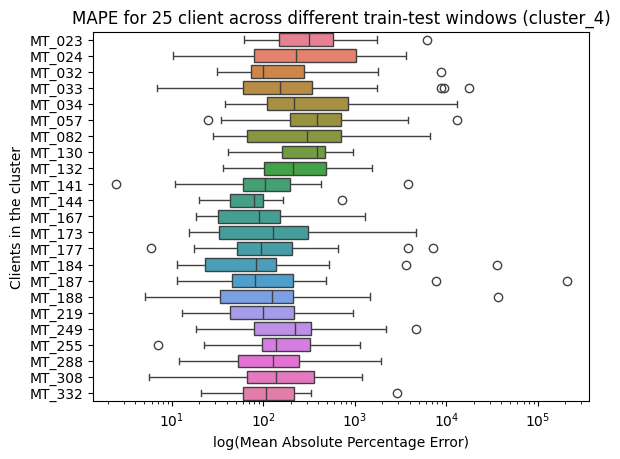

In [33]:
c = ["cluster_1", "cluster_2", "cluster_3", "cluster_4"] 
for i in c:
    m = FacebookProphet_model(weather[366:], electricity23, i, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_step()
    m.mape_boxplot_by_client(25)

# LSTM

In [36]:
class LSTM_model(Model):
    
    def __init__(self, exogs, data, cluster, params: dict, start_index = 0, window_stride = 28):
        self.exogs = exogs
        data["date"] = pd.to_datetime(data["date"])
        data = data.merge(weather.reset_index())
        self.params = params
        super().__init__(data, cluster, start_index, window_stride)

    def restructure(self, X):
        
        x = np.reshape(X[["tmin", "tmax", "precip"]].values, (len(X), 1, 3))
        y = X[self.cluster].values
        
        print(x.shape, y.shape)
        return x, y

    def train_model(self, x_train, y_train):        
        regressor = Sequential()
        regressor.add(Bidirectional(LSTM(units=self.params["num_units"], 
                                         activation=self.params["activation_function"], 
                                         return_sequences=True), 
                                         input_shape=(1,3)))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=self.params["num_units"], activation=self.params["activation_function"], return_sequences=True))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=self.params["num_units"], activation=self.params["activation_function"]))
        regressor.add(Dropout(0.3))
        regressor.add(BatchNormalization())
        regressor.add(Dense(units=64, activation='relu'))
        regressor.add(Dropout(0.2))
        regressor.add(Dense(units=1))

        regressor.compile(optimizer = self.params["optimizer"], loss = self.params["loss_function"])
        regressor.fit(x_train[:self.ts_train - 10], y_train[:self.ts_train - 10], batch_size = self.params["batch_size"], 
                      epochs = self.params["num_epochs"],
                      validation_data = (x_train[self.ts_train - 10:], y_train[self.ts_train - 10:]))

        return regressor
    
    def get_forecasts(self, x_test):

        return self.trained_model.predict(x_test).flatten()
    
    def cross_validate(self):
      
      train_idx = [0, self.ts_train]
      test_idx = [self.ts_train, self.ts_train + self.ts_test]

      for split_id in range(50):
         
         cols = [self.cluster, "tmin", "tmax", "precip"]
         train = self.data[train_idx[0]: train_idx[1]][cols]
         test = self.data[test_idx[0]: test_idx[1]][cols]

         train, test = self.standardize(train, test)

         x_train, y_train = self.restructure(train)
         x_test, y_test = self.restructure(test)

         self.trained_model = self.train_model(x_train, y_train)

         preds = self.get_forecasts(x_test)
         
         self.forecasts[split_id] = {"pred": list(preds),
                                     "train_date_range": train_idx,
                                     "test_date_range": test_idx}
   
         test_np = y_test.flatten()
         mape_by_forecast = np.abs((test_np - self.forecasts[split_id]["pred"])/(test_np))*100
         self.forecasts[split_id]["mape_by_forecast"] = mape_by_forecast

         train_idx = [train_idx[0] + self.ts_window_stride, 
                     min(train_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
         test_idx = [test_idx[0] + self.ts_window_stride, 
                     min(test_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
        
         if test_idx[0] > len(self.data):
            break

(182, 1, 3) (182,)
(5, 1, 3) (5,)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 102.8413 - val_loss: 99.5559
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 107.5216 - val_loss: 100.2086
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 103.2455 - val_loss: 100.4787
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 154.4799 - val_loss: 99.6294
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 102.5529 - val_loss: 99.8017
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 98.8938 - val_loss: 99.9703
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 109.2559 - val_loss: 99.6516
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 101.3920 - val_loss: 99.3300
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 133.9702 - val_loss: 99.0909
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 124.2942 - val_loss: 99.8364
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 97.8270 - val_loss: 99.8610
Epoch 12/50
6/6 ━━━━━━━━━━━━

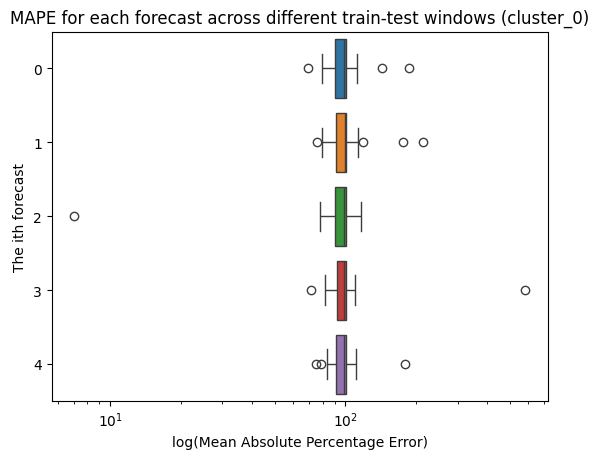

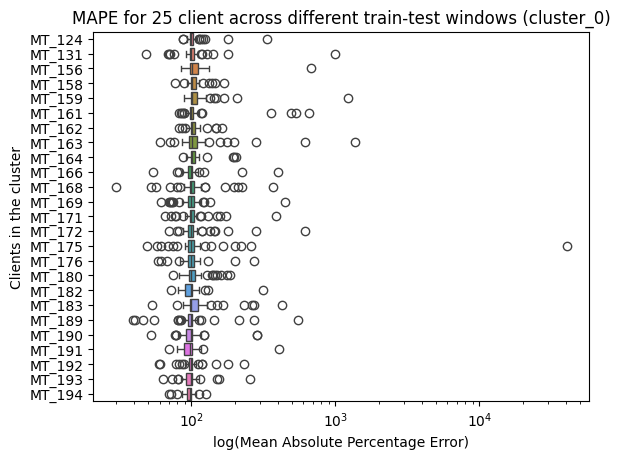

In [37]:
params = {
    "num_units": 60,
    "activation_function": 'relu',
    "optimizer": "adam",
    "loss_function": "mean_absolute_percentage_error",
    "batch_size": 32,
    "num_epochs": 50
}

m = LSTM_model(weather.reset_index(), electricity0.reset_index(), "cluster_0", params)
m.cross_validate()
m.mape_boxplot_by_step()
m.mape_boxplot_by_client(25)

# m = LSTM_model(weather.reset_index(), np.log(electricity/4).reset_index(), "cluster_0", params, window_stride = 28)

(182, 1, 3) (182,)
(5, 1, 3) (5,)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 100.2467 - val_loss: 99.9203
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 98.0677 - val_loss: 100.1293
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 100.4263 - val_loss: 100.1304
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 101.7742 - val_loss: 100.2889
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 103.2991 - val_loss: 100.3384
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 98.4225 - val_loss: 100.0803
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 106.4099 - val_loss: 99.9525
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 97.1354 - val_loss: 99.7367
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 98.8140 - val_loss: 100.0145
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 105.6727 - val_loss: 100.1747
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 95.8745 - val_loss: 100.2754
Epoch 12/50
6/6 ━━━━━━━━━

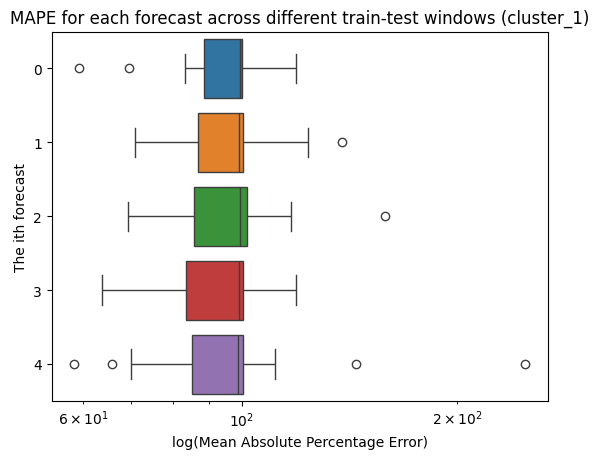

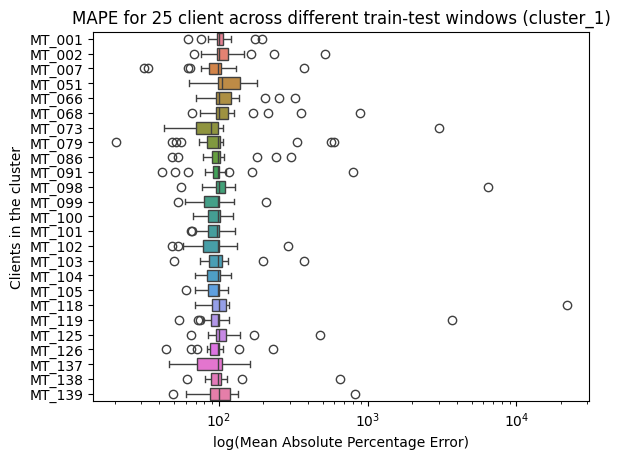

(182, 1, 3) (182,)
(5, 1, 3) (5,)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 100.6231 - val_loss: 100.0580
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 103.5844 - val_loss: 95.1148
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 97.5951 - val_loss: 101.8831
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101.1121 - val_loss: 110.3163
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97.2340 - val_loss: 124.1152
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 106.7398 - val_loss: 126.3240
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 106.3004 - val_loss: 121.8120
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 95.9783 - val_loss: 116.8989
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 92.2723 - val_loss: 106.1758
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 93.9212 - val_loss: 104.1839
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 94.6218 - val_loss: 117.4344
Epoch 12/50
6/6 ━━━━━━━━

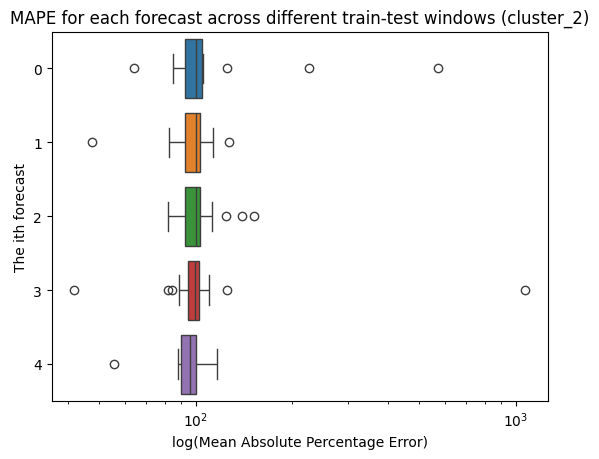

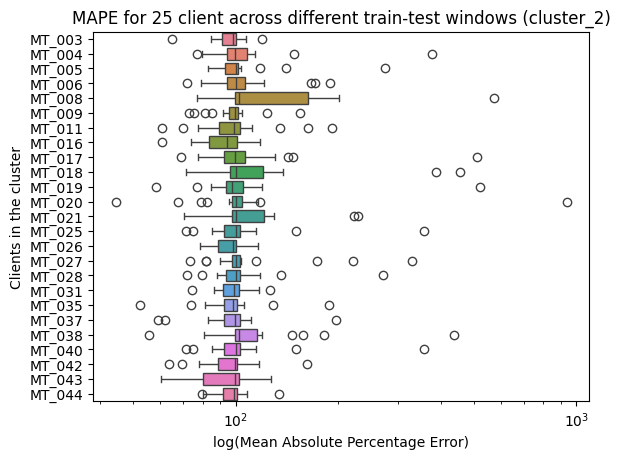

(182, 1, 3) (182,)
(5, 1, 3) (5,)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 98.9031 - val_loss: 98.1003
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.2626 - val_loss: 95.4984
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 88.1187 - val_loss: 92.1659
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 80.6506 - val_loss: 88.3398
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 77.9375 - val_loss: 84.6810
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76.9736 - val_loss: 85.5550
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 69.5983 - val_loss: 85.4183
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 77.9406 - val_loss: 85.1360
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 71.4163 - val_loss: 85.0320
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 73.1314 - val_loss: 84.9193
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 72.7937 - val_loss: 85.0971
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s

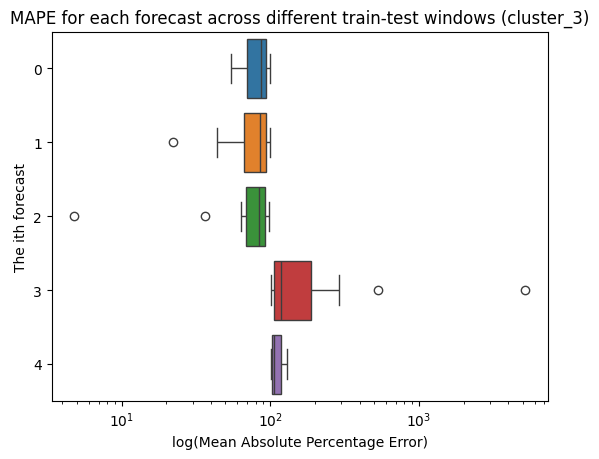

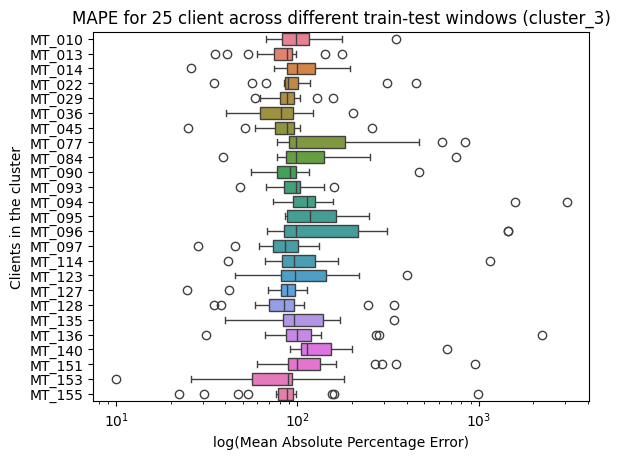

(182, 1, 3) (182,)
(5, 1, 3) (5,)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 98.7288 - val_loss: 101.1107
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 100.8073 - val_loss: 100.5328
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 101.5123 - val_loss: 99.7091
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 99.9521 - val_loss: 99.6623
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 105.4605 - val_loss: 100.3358
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 103.2345 - val_loss: 101.2038
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 102.0182 - val_loss: 101.7967
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 103.4170 - val_loss: 101.5060
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 103.0701 - val_loss: 101.0291
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 99.3317 - val_loss: 100.4029
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 99.1974 - val_loss: 99.9467
Epoch 12/50
6/6 ━━━━━━━━

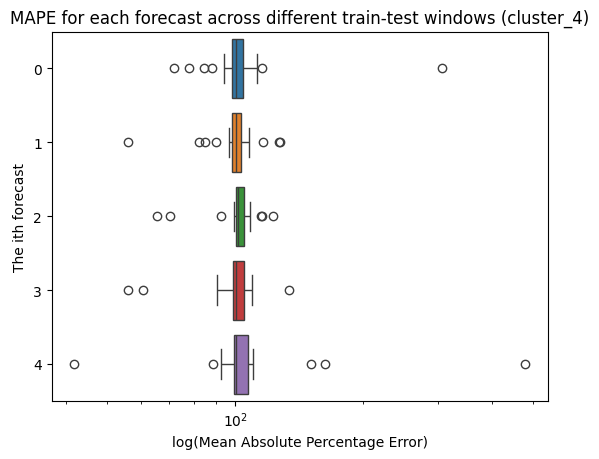

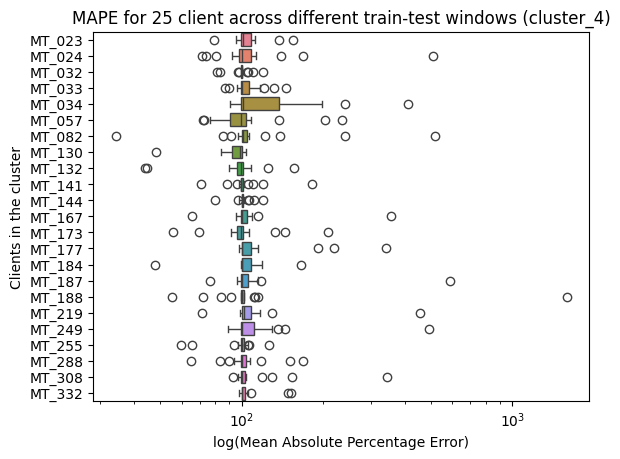

In [38]:
c = ["cluster_1", "cluster_2", "cluster_3", "cluster_4"] 
for i in c:
    m = LSTM_model(weather[366:].reset_index(), electricity23[366:].reset_index(), i, params, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_step()
    m.mape_boxplot_by_client(25)